In [1]:
import tensorflow as tf
import cv2
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19

import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# Load the pre-trained model
model = tf.keras.models.load_model("F:/SkinDisease/Day4/vgg19_melanoma_model_32.h5")

In [3]:
num_classes = model.output_shape[-1]
print("Number of classes:", num_classes)

Number of classes: 9


In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
trainset = train_datagen.flow_from_directory("F:/SkinDisease/newdata/Melanoma/Train",
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical", shuffle=True)

Found 17728 images belonging to 9 classes.


In [7]:
testset = test_datagen.flow_from_directory("F:/SkinDisease/newdata/Melanoma/Valid",
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical", shuffle=False)

Found 7603 images belonging to 9 classes.


In [8]:
class_dict = trainset.class_indices
class_labels = list(class_dict.keys())
class_labels

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

In [9]:
# Function to preprocess an image
def preprocess_image(image):
    # Preprocess the image (resize, normalize, etc.)
    # Modify this function according to your preprocessing requirements
    preprocessed_image = cv2.resize(image, (224, 224))
    preprocessed_image = preprocessed_image / 255.0  # Normalize pixel values
    return preprocessed_image

In [10]:
def predict_single_image(image_path):
    try:
        # Load and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Failed to load image. Please check the image file.")

        preprocessed_image = preprocess_image(image)

        # Add a batch dimension to match the model's input shape
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

        # Make predictions
        predictions = model.predict(preprocessed_image)

        # Get the predicted class label and percentage
        predicted_class_index = np.argmax(predictions)
        predicted_class_label = class_labels[predicted_class_index]
        predicted_percentage = predictions[0][predicted_class_index] * 100

        return predicted_class_label, predicted_percentage
    except Exception as e:
        print("Error:", str(e))
        return None, None

In [11]:
# Function to display an image
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Function to predict images in a folder
def predict_image_folder(folder_path):
    # Get the list of image file names in the folder
    image_files = os.listdir(folder_path)

    # Iterate over the image files and make predictions
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        # Load and preprocess the image
        image = cv2.imread(image_path)
        preprocessed_image = preprocess_image(image)

        # Add a batch dimension to match the model's input shape
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

        # Make predictions
        predictions = model.predict(preprocessed_image)

        # Get the top 3 predicted class labels and percentages
        top_indices = np.argsort(predictions[0])[::-1][:3]
        top_classes = [class_labels[idx] for idx in top_indices]
        top_percentages = [predictions[0][idx] * 100 for idx in top_indices]

         # Display the image
        display_image(image)
        print(f"Image: {image_file}")
        for i in range(len(top_classes)):
            print(f"Predicted Class {i+1}: {top_classes[i]}")
            print(f"Percentage: {top_percentages[i]}%")
            print()
        print()

In [15]:
# Usage example for predicting a single image
image_path = "F:/SkinDisease/testing/test2.jpeg"
predicted_label, predicted_percentage = predict_single_image(image_path)
print(f"Predicted Label: {predicted_label}")
print(f"Percentage: {predicted_percentage}%")

1/1 [==============================] - 3s 3s/step
Predicted Label: BKL
Percentage: 88.43759298324585%


1/1 [==============================] - 1s 845ms/step


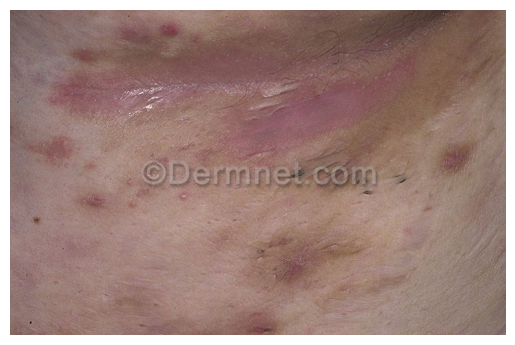

Image: hidradenitis-suppurativa-39.jpg
Predicted Class 1: NV
Percentage: 80.45986294746399%

Predicted Class 2: BKL
Percentage: 13.218596577644348%

Predicted Class 3: MEL
Percentage: 6.264045089483261%


1/1 [==============================] - 1s 772ms/step


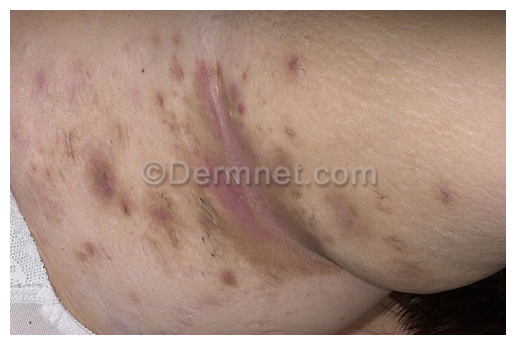

Image: hidradenitis-suppurativa-40.jpg
Predicted Class 1: NV
Percentage: 65.3292715549469%

Predicted Class 2: VASC
Percentage: 16.624808311462402%

Predicted Class 3: BKL
Percentage: 14.924348890781403%


1/1 [==============================] - 1s 768ms/step


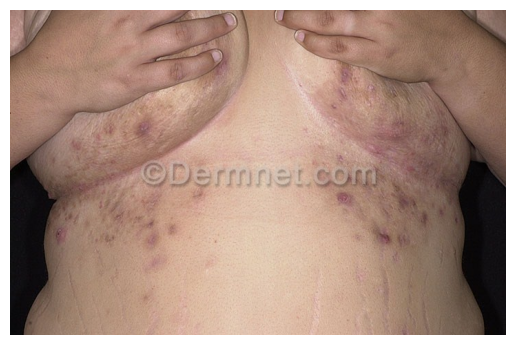

Image: hidradenitis-suppurativa-42.jpg
Predicted Class 1: NV
Percentage: 99.89049434661865%

Predicted Class 2: BKL
Percentage: 0.05641880561597645%

Predicted Class 3: MEL
Percentage: 0.04894909798167646%


1/1 [==============================] - 1s 776ms/step


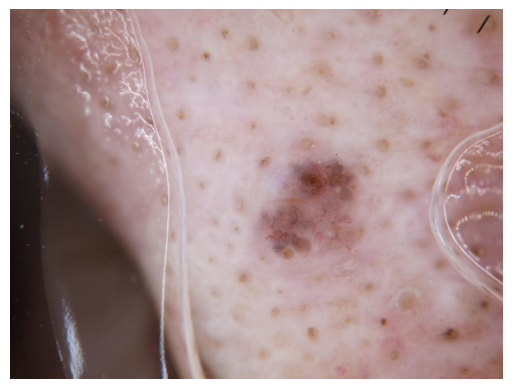

Image: ISIC_0024432.jpg
Predicted Class 1: BCC
Percentage: 90.41280150413513%

Predicted Class 2: MEL
Percentage: 5.782096832990646%

Predicted Class 3: NV
Percentage: 3.59150730073452%


1/1 [==============================] - 1s 779ms/step


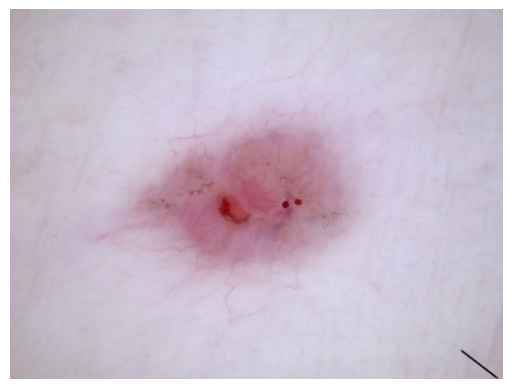

Image: ISIC_0024436.jpg
Predicted Class 1: NV
Percentage: 74.78843331336975%

Predicted Class 2: BCC
Percentage: 24.562393128871918%

Predicted Class 3: VASC
Percentage: 0.4228874109685421%


1/1 [==============================] - 1s 945ms/step


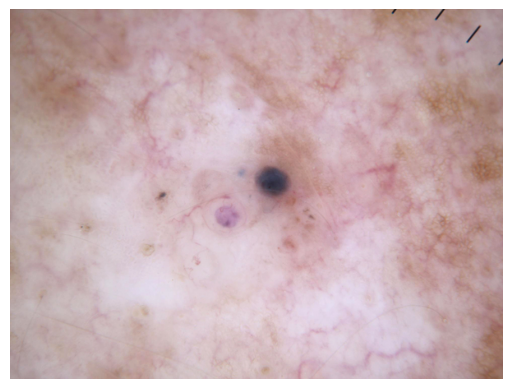

Image: ISIC_0024443.jpg
Predicted Class 1: BCC
Percentage: 96.76372408866882%

Predicted Class 2: NV
Percentage: 1.7960559576749802%

Predicted Class 3: BKL
Percentage: 1.0026149451732635%


1/1 [==============================] - 1s 740ms/step


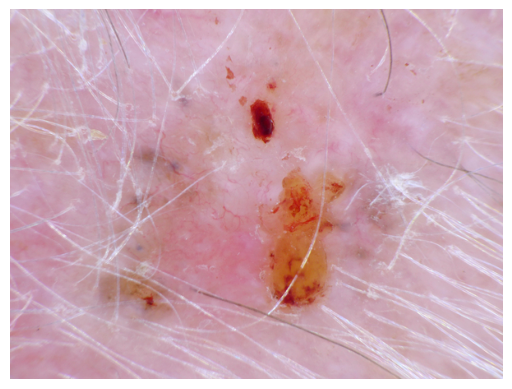

Image: ISIC_0024504.jpg
Predicted Class 1: BCC
Percentage: 45.330968499183655%

Predicted Class 2: VASC
Percentage: 26.23276114463806%

Predicted Class 3: NV
Percentage: 13.15845251083374%


1/1 [==============================] - 1s 665ms/step


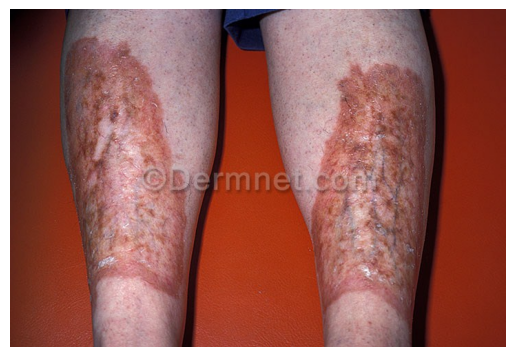

Image: necrobiosis-lipoidica-62.jpg
Predicted Class 1: NV
Percentage: 99.99984502792358%

Predicted Class 2: MEL
Percentage: 0.00015641911659258767%

Predicted Class 3: BKL
Percentage: 5.344726328182503e-08%


1/1 [==============================] - 1s 649ms/step


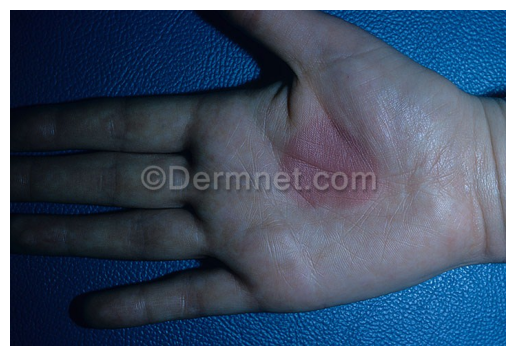

Image: test1.jpg
Predicted Class 1: MEL
Percentage: 94.56730484962463%

Predicted Class 2: NV
Percentage: 5.274241045117378%

Predicted Class 3: BKL
Percentage: 0.14383031520992517%


1/1 [==============================] - 1s 749ms/step


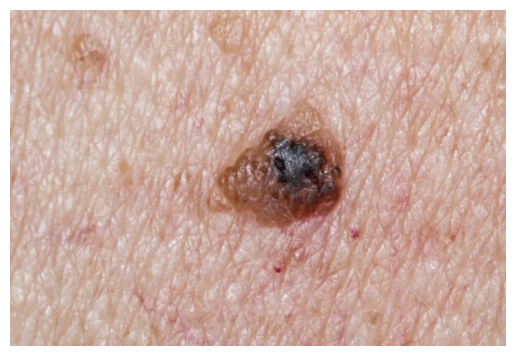

Image: test2.jpeg
Predicted Class 1: BKL
Percentage: 88.43759298324585%

Predicted Class 2: NV
Percentage: 11.04646846652031%

Predicted Class 3: MEL
Percentage: 0.3702300600707531%




In [16]:
# Usage example for predicting images in a folder
folder_path = "F:/SkinDisease/testing"
predict_image_folder(folder_path)